In [2]:
# Importing necessary libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


tensorflow_datasets (imported as tfds): This library provides convenient access to a variety of datasets, including the MNIST dataset.

By preparing the dataset, TensorFlow Datasets aims to provide a convenient and standardized interface for machine learning practitioners, making it easier to access and work with various datasets without having to manually perform these steps. This allows researchers and developers to focus more on building and experimenting with machine learning models rather than dealing with the intricacies of data preparation.

In [4]:
# Loading the MNIST dataset
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']
# Printing a success message
print('Successfully executed')


Successfully executed


In [5]:
# Loading the MNIST dataset again with info
mnist_test, info = tfds.load(name="mnist", with_info=True)
print(info)


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [6]:
# Setting constants for data processing
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20


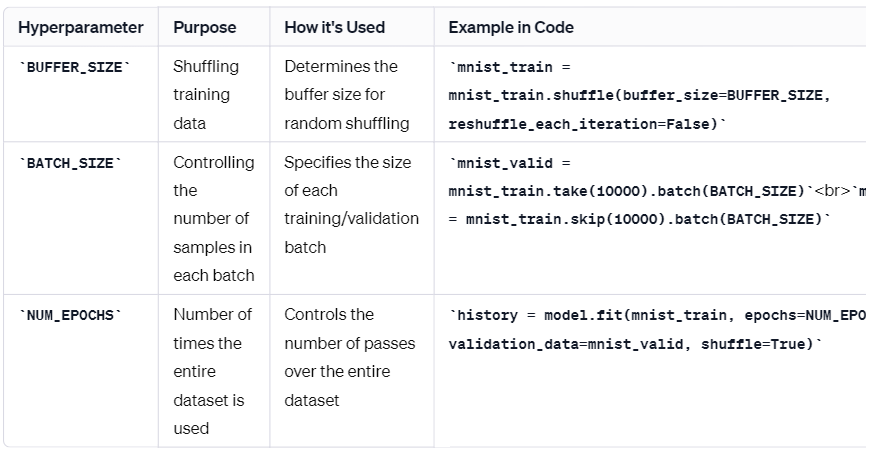

In [10]:
mnist_train = mnist_train_orig.map(lambda item: (tf.cast(item['image'], tf.float32) / 255.0, tf.cast(item['label'], tf.int32)))
mnist_test = mnist_test_orig.map(lambda item: (tf.cast(item['image'], tf.float32) / 255.0, tf.cast(item['label'], tf.int32)))


 Each element in these datasets is a dictionary containing an 'image' and a 'label'.

 The map function is used to apply a function to each element of the dataset. In this case, a lambda function is defined to perform the following operations on each element (item) of the dataset:
tf.cast(item['image'], tf.float32) / 255.0: This line converts the pixel values of the 'image' to floating-point numbers and then scales them by dividing by 255.0. This operation normalizes the pixel values to the range [0, 1].
tf.cast(item['label'], tf.int32): This line casts the 'label' to 32-bit integers. This is often necessary for compatibility with the model's architecture and loss function.

After these operations, mnist_train and mnist_test are new datasets where each element is a tuple (image, label). The images are normalized to the range [0, 1], and the labels are cast to 32-bit integers.

In [13]:
tf.random.set_seed(1)
mnist_train=mnist_train.shuffle(buffer_size=BUFFER_SIZE,reshuffle_each_iteration=False)
mnist_valid=mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train=mnist_train.skip(10000).batch(BATCH_SIZE)
# Dataset skips 10000 elements because 10000 elements are alloted to validation dataset
print('Successfully executed')

Successfully executed


In [15]:
#Constructing a CNN
model=tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(5,5),strides=(2,2),padding='same',data_format='channels_last',name='conv_1',activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),name='pool_1'))

model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',data_format='channels_last',name='conv_2',activation='relu')) # Vary
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),name='pool_2')) #Vary

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=1024,activation='relu')) # Vary
model.add(tf.keras.layers.Dropout(rate=0.5)) # Vary
model.add(tf.keras.layers.Dense(units=1024,activation='softmax'))
model.build(input_shape=(None,28,28,1))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 14, 14, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 32)          0         
                                                                 
 conv_2 (Conv2D)             (None, 7, 7, 64)          51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 3, 3, 64)          0         
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 1024)              590848    
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [16]:

model.compile(optimizer='adam',loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

history=model.fit(mnist_train,epochs=1,validation_data=mnist_valid,shuffle=True) # Batch_size =64
print('Successfully executed')



/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


782/782 [==============================] - 76s 93ms/step - loss: 0.3677 - accuracy: 0.8910 - val_loss: 0.0771 - val_accuracy: 0.9742
Successfully executed


In [17]:
test_results=model.evaluate(mnist_test.batch(20))
print('Test Acc.{:.2f}\%'.format(test_results[1]*100))

500/500 [==============================] - 6s 12ms/step - loss: 0.0673 - accuracy: 0.9773
Test Acc.97.73\%


TensorShape([10, 1024])
tf.Tensor([2 0 4 8 7 6 0 6 3 1], shape=(10,), dtype=int64)


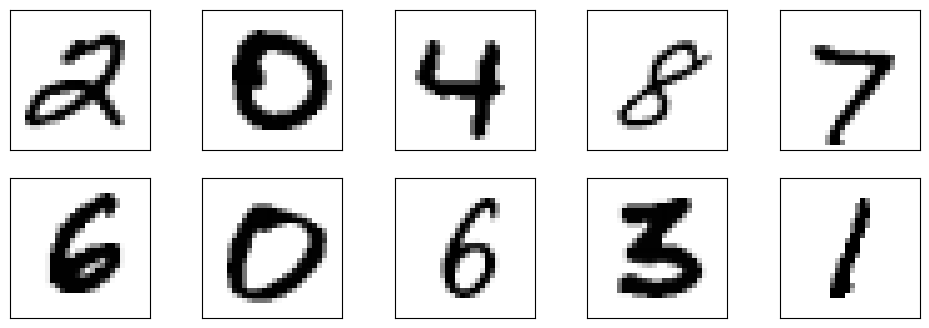

In [23]:
#import numpy as np
batch_test=next(iter(mnist_test.batch(10)))
preds=model(batch_test[0])
tf.print(preds.shape)
preds=tf.argmax(preds,axis=1)
print(preds)

#plt.show()
fig=plt.figure(figsize=(12,4))
for i in range(10):
  ax=fig.add_subplot(2,5,i+1)
  ax.set_xticks([]);ax.set_yticks([])
  img=batch_test[0][i,:,:,0]
  ax.imshow(img,cmap='gray_r')
plt.show()